<a href="https://colab.research.google.com/github/annhater/isdd_projects/blob/main/ai_2/protein_structure_representation_learning_Anna_PEROVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>
Protein Structure Representation Learning<br>
<small style="color:gray;">(Part 2 of Deep Learning for Protein Series)</small>
</h1>

**About the practical:**
* Here, we specifically focus on Representation Learning
* We use 3D-CNNs to identify amino acids by their structure and evaluate Protein-Protein Interfaces (PPI)
* The model will explore local environments around residues at an interface
* Voxel-based view (3D) allows the model to capture the spatial context required to understand how residues interact across an interface, which is often lost in a simple linear string.

**Notions**
* Voxelization: The process of converting 3D geometric information (atom coordinates) into a discrete grid of small cubes called voxels. Each voxel stores information about the chemical/physical properties of that spatial point. (like pixel but in 3D)
* Local vs. Global Representation
  * Global grids represent the whole interface but are memory-inefficient
  * Local representation uses frames centered on individual residues to handle large or complex interfaces more effectively.
  * Rotational Symmetry & SE(3)-Equivariance: Traditional CNNs are sensitive to rotation. By using oriented local frames, the model becomes invariant to the global rotation of the protein without needing complex data augmentation
  * Voxel Density Map: Calculated using a Gaussian distribution to represent atom presence: d(v)=∑exp(−(v−ai​)2/σ2)⋅ti​.

**Packages/Functions used**
* TensorFlow & Keras (Used for building and training the 3D-CNN architectures that process the voxelized volumetric maps, handle grid data structures)
* scikit-learn library (machine learning model training and evaluation metrics (like Accuracy and Confusion Matrices))
* Matplotlib/Seaborn: Used for visualizing model performance and confusion matrices (frequencies vs. occurrences).

**Goal:**
* Develop, train, and validate deep learning models to analyze and interpret protein-protein interactions.

**3D-CNN model architecture:**
* Learn low-dimensional continuous vector representations (embeddings) from volumetric maps to classify residues or score docking poses.

# 1. Introduction

Protein–protein interactions are fundamental to virtually all biological processes. The ability to accurately predict which proteins interact, and how they associate at the molecular level, would have tremendous implications for bioengineering and medicine. Substantial effort has been devoted to developing computational and experimental methods for modeling and simulating protein–protein complexes.

<p align="center">
<img src='https://drive.google.com/uc?id=1mcGnP7qPuVXt5LuwAjy1Es4ZvMBFlTh4' width="300"/>
</p>

Protein–protein complexes are formed through specific interaction interfaces, and the properties of these interfaces govern the formation, specificity, and stability of the complex. Each protein can interact with multiple partners through distinct interfaces. In some cases, the same interface can bind different proteins, often with varying binding affinities.

<p align="center">
<img src='https://drive.google.com/uc?id=19MHqRpG7uKQP-iP3uLWXd1W6J_SCWzxB' width="500"/>
</p>

By analyzing protein–protein interfaces, we can assess:
* The stability of the protein–protein complex
* The binding affinity between proteins
* The impact of mutations on complex formation and binding affinity
* The quality of the modeled protein–protein complex, whether created by docking or fold-and-dock (AI tools) and enable:
* The rational design of protein interfaces that are geometrically and physico-chemically compatible with a target receptor

These analyses have wide-ranging applications in elucidating how protein–protein interactions regulate cellular mechanisms and in enabling the rational design of selective and effective therapeutic agents Therefore, a comprehensive understanding of the molecular mechanisms governing protein-protein interactions is essential.



# 2. Decoding protein-protein interactions with deep learning models

## Protein representation


In this hands-on session, you will develop, train, and validate deep learning models to analyze and interpret protein-protein interactions.

As discussed earlier in the course, proteins can be represented in multiple ways, each requiring a distinct approach to representation learning. For instance, the interface between two proteins can be modeled as volumetric cubes, allowing 3D convolutional neural networks (3D-CNNs) to extract abstract features from the spatial arrangement of atoms.

<p align="center">
<img src='https://drive.google.com/uc?id=1255_mYSr_ANn3uU595kI7luWZwFN-1mc' width="300"/>
</p>

Alternatively, the interface can be represented as a graph, with atoms or residues as nodes and covalent and non-covalent interactions as edges. In this case, graph neural networks (such as graph convolutional networks) can learn the topology and composition of the interface.

<p align="center">
<img src='https://drive.google.com/uc?id=1BSPbvPzOvYCLQi8m-W-QKyvrLZhvSeuN' width="300"/>
</p>

In this session, we will focus on the volumetric cube representation, capturing the three-dimensional arrangement of atoms at the protein interface.

## Voxalized 3D grid


Similar to a pixelized image, which represents a 2D picture as a grid of tiny squares, called **pixels**, a voxelized grid represents a 3D picture as a grid of small cubes called **voxels**. Each voxel stores information about that part of the space, enabling complex 3D shapes or volumes to be captured and analyzed computationally, much like images are processed in computer vision.

<p align="center">
<img src='https://drive.google.com/uc?id=1pTJQ-AjUO8-FFs4aixUaCg1cShbFNzhu' width="600"/>
</p>

We can extend the same voxelization concept to represent the 3D arrangement of atoms in space.

<p align="center">
<img src='https://drive.google.com/uc?id=1PtTsvA7uili5aveL5UpJPftRgsilnuQX' width="600"/>
</p>


In our practical session, we will see how to extract meaningful information from this voxelized representation using standard 3D convolutional neural networks (**3D-CNNs**).

## Global representation vs local representation

One can represent the entire protein-protein interface as one whole voxelized 3D grid.

<p align="center">
<img src='https://drive.google.com/uc?id=1G6udkC8tdvDsFfXemcG1HITneo2P7ZhQ' width="700"/>
</p>

What are the problems with this representation?

This representation has two limitations:

* First, when a fixed-size cube is used as grid, it might not cover very large and/or discontinuous interfaces. Using a very large cube to accommodate any interface is memory inefficient. Large cubes of fixed size may also hinder the accuracy in case of small interfaces due to the information vanishing after a few layers of pooling.

* Second, since the 3D-CNN does not benefit from the rotational symmetry endowed to the Euclidean space, it is sensitive to the orientation of the candidate conformation and its output may change upon rotation of the input in an uncontrolled fashion.

Alternatively, one can leverage the specific properties of proteins, whose building blocks (the amino acid residues) share the same chemical scaffold, to derive a SE(3)-equivariant representation. These properties allow us to rely on <font color="red"><b><i>oriented local frames centered</i></b></font> on each residue's backbone geometry, containing the local 3D atomic arrangements. Such representation circumvents the problem of 3D rotational symmetry without the need for rotational data augmentation nor for SE(3)-equivariant convolutional filters.


<p align="center">
<img src='https://drive.google.com/uc?id=19egtSEU1-XIsdyTjzrEb6EZ2J8pm4pzp' width="400"/>
</p>



# 3. Amino acids and their local environments

## Can a machine identify an amino acid by its structure? <font color="Green">(Optional)</font>

**Task 1**: Take a look at the following amino acid structures. Can you distinguish between the different amino acids?

<font color="Blue">Nitrogen: Blue</font>,  <font color="Green">Carbon: Green</font>, <font color="Red">Oxygen: Red</font>, <font color="Gold">Sulfur: Yellow</font>

<p align="center">
<img src='https://drive.google.com/uc?id=1cltgrjlxVcVkx-TffmExqvBq7jpHxN_L'>
</p>

Now take a look at the following amino acids and recognize which structure they belong to.

<p align="center">
<img src='https://drive.google.com/uc?id=14TWwgKaHNAjMHyF5Nae_yOT_jI5jkQjC'  width="600">
</p>

- Did the rotation of the amino acids or changes in the side-chain and backbon torsion angles influence your decisions?
- What deep learning approach do you propose for the classification of amino acids structures?
- Does traditional CNN do the job for us?

The amino acids from left ro right and top to bottom are: . The rotation of aa and backbone torision did not influence my decisions because. We can propose a supervised deep learning approach, such as classification. The model would learn the properties of each aa and output the proposed aa class based on this learned data.

## Local environment around a residue at the interface <font color="Green">(Optional)</font>

**Task 2**: Analyze a crystal structure of SARS-CoV-2 spike receptor-binding domain (RBD) in interaction with Angiotensin-Converting Enzyme 2 (ACE2). PDB code: 6M0J

<p align="center">
<img src='https://drive.google.com/uc?id=1vLnGo0aO5hDwdFqTD49ieAMArq3Kvx6I' width="300">
</p>

- Download the structure of biological assembly of this complex and visualize it in pymol.

- By what experimental method the structure of this complex is determined?

- Select spike glycoprotein (it's chain E). You can do this using command `select Spike, chain E`.

- Select ACE2 (it's chain A). You can do this using command `select ACE2, chain A`.

- Can you identify the interface between these two chains?

- Select residue 382 from chain A and rename it to `centralRes`. Use command `set_name sele, centralRes`. What is the name of this residue and what are its characteristics?

- Represent this residue with spheres using commands `show spheres, centralRes` and `set sphere_scale, 0.6`.

- Select the environment around this residue (6 $Å$) and name it `env`. Use command `select env, byres(centralRes around 6) + centralRes`.

- Show `env` as sticks. Use command `show sticks, env`.

- From the action menu (A) on `env` orient the visualisation on it.

- From the action menu (A) on `env` find all the polar contacts. `file->polar contacts->whitin selection`.

- Analyze the environment.

- Now repeat the same process for residue 487, 489, 498, and 500 from chain E.

## Interfaces as a set of locally oriented cubes


In this hands-on session, the interface is represented as a collection of locally oriented cubic volumetric maps of side 19.2 Å, voxelized into cubes of 24×24×24. Each cube is centered on a central residue, and is oriented according to the residue’s backbone geometry. It contains the 3D atomic arrangement of the central residue and its local environment. This representation is therefore invariant to global 3D translations and rotations.

<p align="center">
  <img src='https://drive.google.com/uc?id=14z9H8JxW9AjLDLacPcIKV_DpkER3hN1I' width="900"/>
</p>

For better understanding of the properties of locally oriented cubes please review [this article](https://academic.oup.com/bioinformatics/article/35/18/3313/5341430?login=true).

# 4. Learning an amino acid from its local environment?

Can a machine learn an amino acid from its local environment? In this section we will develop an end-to-end architecture to predict the amino acid from its environment.

## Setting up packages

We will be working with **TensorFlow** and **Keras**, two widely used frameworks for handling grid-like data structures. Additionally, we will use the **scikit-learn** library, which provides essential tools for machine learning model training and evaluation.

In [1]:
#Usual stuff
import pandas as pd
import numpy as np
import logging
import seaborn as sns
from math import exp
from tqdm import tqdm
from random import shuffle, random, seed, sample
import matplotlib.pyplot as plt
import time, os, sys, glob, gc, pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#Tensorflow and Keras for deep learning
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, AveragePooling3D, GlobalAveragePooling3D, SpatialDropout3D, Dense, Dropout, Activation, Flatten, Concatenate, Dot, BatchNormalization, Add, Lambda
from tensorflow.keras.backend import ones, ones_like
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l2

#scikit-learn for machine learning and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, log_loss
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [ ]:
print('Your python version: {}'.format(sys.version_info.major))

Your python version: 3



```
code to verify the python environment and GPU:
```



In [ ]:
USE_TENSORFLOW_AS_BACKEND = True
FORCE_CPU = False

if USE_TENSORFLOW_AS_BACKEND:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
else:
    os.environ['KERAS_BACKEND'] = 'theano'
if FORCE_CPU:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
if USE_TENSORFLOW_AS_BACKEND == True:
    import tensorflow
    print('Your tensorflow version: {}'.format(tensorflow.__version__))
    print("GPU : "+tensorflow.test.gpu_device_name())
else:
    import theano
    print('Your theano version: {}'.format(theano.__version__))

Your tensorflow version: 2.19.0
GPU : 


## The input data: locally oriented cubes

In this hands-on session, the input data is already provided. The command below downloads a dataset of residue samples with their environments. These are structured residues found at the interface of different protein-protein complexes (interfacial residues).

You can click the folder icon on the left to view the data in your home repository.

In [5]:
!gdown --id '1c8mL6t31BR4Th0qyfPoeNOKU-OPI1dNd'

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1c8mL6t31BR4Th0qyfPoeNOKU-OPI1dNd
From (redirected): https://drive.google.com/uc?id=1c8mL6t31BR4Th0qyfPoeNOKU-OPI1dNd&confirm=t&uuid=f9148bdb-a505-4345-9cae-4a92e8d7240a
To: /content/traindata_env_30.zip
100% 80.9M/80.9M [00:01<00:00, 74.8MB/s]


The command below decompresses the dataset.

In [6]:
!unzip -o -q '/content/traindata_env_30.zip'

The command below creates a list of all the samples.

In [7]:
samples = glob.glob(os.path.join('traindata_env_30', '*.pkl'))

Because the data is compressed using the `pickle` module, we will define the following helper functions to serialize and deserialize the pickle object structure.

In [8]:
#decoding of the samples: useful functions
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

**Task 3**: Read one of the samples and explore its contents. Each sample contains three elements: cube (`sample_X`), target (`sample_y`), and label (`sample_resname`). Your goal is to investigate these elements by executing the code below. Try to determine:

- The purpose of each element
- Their dimensions or shape
- Their content

In [9]:
sample_X, sample_y, sample_resname = load_obj(samples[1].replace('.pkl',''))

# YOUR CODE HERE
#purpose:
#cube (sample_x) = voxel cube centered on the aminoacid residue (cube dimensions: 24*24*24)
#target (sample_y) = a vector representing the central aminoacid in the cube
#label (sample_resname) = label that represents the central aminoacid

print(f"Cube dimensions {(sample_X).shape}")
print(f"Aminoacid on which the cube is centered: {sample_resname}")
print(f"Vector of length {len(sample_y)}, coding for central aminoacid :{sample_y}")


Cube dimensions (24, 24, 24, 167)
Aminoacid on which the cube is centered: THR
Vector of length 20, coding for central aminoacid :[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


`sample_X` is a 4-dimensional array with 167 channels along the fourth dimension, each encoding *residue-specific* atomic information.

`sample_y` is a one-hot encoded vector of 20 elements, representing the central amino acid. The amino acids in this vector are ordered alphabetically.:

`ALA  ARG  ASN  ASP  CYS  GLN  GLU  GLY  HIS  ILE  LEU  LYS  MET  PHE  PRO  SER  THR  TRP  TYR  VAL`

`sample_resname` is the name of the central amino acid.

The `sample_X` array has 167 channels in its 4th dimension, which is quite high! This is because it encodes every atom of each amino acid, which can be a bit redundant. The code below aims to simplify this representation by reducing the number of channels to just 4, corresponding to the four main heavy atoms: Carbon, Oxygen, Nitrogen, and Sulfur.

In [23]:
#Amino acids and their atomic composition
channels = {'ALA':['C','N','O','CA','CB'],
            'ARG':['C','N','O','CA','CB','CG','CD','NE','CZ','NH1','NH2'],
            'ASN':['C','N','O','CA','CB','CG','ND2','OD1'],
            'ASP':['C','N','O','CA','CB','CG','OD1','OD2'],
            'CYS':['C','N','O','CA','CB','SG'],
            'GLN':['C','N','O','CA','CB','CG','CD','NE2','OE1'],
            'GLU':['C','N','O','CA','CB','CG','CD','OE1','OE2'],
            'GLY':['C','N','O','CA'],
            'HIS':['C','N','O','CA','CB','CG','CD2','ND1','CE1','NE2'],
            'ILE':['C','N','O','CA','CB','CG1','CG2','CD1'],
            'LEU':['C','N','O','CA','CB','CG','CD1','CD2'],
            'LYS':['C','N','O','CA','CB','CG','CD','CE','NZ'],
            'MET':['C','N','O','CA','CB','CG','SD','CE'],
            'PHE':['C','N','O','CA','CB','CG','CD1','CD2','CE1','CE2','CZ'],
            'PRO':['C','N','O','CA','CB','CG','CD'],
            'SER':['C','N','O','CA','CB','OG'],
            'THR':['C','N','O','CA','CB','CG2','OG1'],
            'TRP':['C','N','O','CA','CB','CG','CD1','CD2','CE2','CE3','NE1','CZ2','CZ3','CH2'],
            'TYR':['C','N','O','CA','CB','CG','CD1','CD2','CE1','CE2','CZ','OH'],
            'VAL':['C','N','O','CA','CB','CG1','CG2']}
v_dim = 24
n_channels = 4

all_channels = []
for aa, a_vector in channels.items():
    all_channels += a_vector

C_index, O_index, N_index, S_index = [], [], [], []
for i,a in enumerate(all_channels):
    if a[0] == "C":
        C_index.append(i)
    if a[0] == "O":
        O_index.append(i)
    if a[0] == "N":
        N_index.append(i)
    if a[0] == "S":
        S_index.append(i)
#this wil reduce the nb of channels from 167 to 4
def reduce_channels(X):
    try:
        X_new = np.zeros(X.shape[:-1] + tuple([n_channels]))

        X_new[:,:,:,0] = X[:,:,:,C_index].sum(axis=3)
        X_new[:,:,:,1] = X[:,:,:,N_index].sum(axis=3)
        X_new[:,:,:,2] = X[:,:,:,O_index].sum(axis=3)
        X_new[:,:,:,3] = X[:,:,:,S_index].sum(axis=3)
    except:
        pass
    return X_new

Next, we will load all the samples and create two variables: `X`, containing the cubic information, and `y`, containing the labels. We ignore `resname` because it cannot be interpreted by the deep learning architecture and its information is already encoded in `y`.

In [24]:
X, y = [],[]
for sample in tqdm(samples):
  #print('Loading ' + sample)
  sample_X, sample_y, sample_resname = load_obj(sample.replace('.pkl',''))
  sample_X = reduce_channels(sample_X)
  X.append(np.array(sample_X))
  y.append(np.array(sample_y))
X = np.array(X)
y = np.array(y)

100%|██████████| 595/595 [00:12<00:00, 48.06it/s]


What is the shape of a element from `X` array?

In [25]:
# YOUR CODE HERE
print(X.shape)

(595, 24, 24, 24, 4)


**Task 4**: Split data into train and test sets using `train_test_split` function from `scikit-learn`. Use `test_size=0.3`.

In [26]:
seed(np.random.randint(0, 11))

# YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#X and y are no longer needed, so we delete them.
%xdel X
%xdel y
gc.collect()

222

What is the shape of `X_test`? Explain each dimension.

In [27]:
# YOUR CODE HERE
print(X_test.shape)
print(f"Number of cubes that will be used for testing: {len(X_test)}")
print(f"Dimension of each cube + number of channels encoded in cube: {X_test[0].shape}")

(179, 24, 24, 24, 4)
Number of cubes that will be used for testing: 179
Dimension of each cube + number of channels encoded in cube: (24, 24, 24, 4)


## Deep learning architecture based on 3D-CNN

**Task 5**: Develop a deep learning architecture based on 3D-CNN. Below is a function that builds the model architecture. Your aim is to complete this architecture using the following instructions:

* **Convolutional layers**

  * Use the `Conv3D` class from `Keras` to define 3D-CNN layers.
  * Define a few layers of 3D-CNN. Try 2, 3, or 4 layers.
  * Each layer maps the number of channels (which is 4) to a feature map of size 20 or 30 (you can try other sizes).
  * Each layer has a kernel or filter of size 3 or 4. If you choose a kernel of size 1, it only acts as a projector and maps the channels without analyzing the relative and local structural priors of the grid.
  * Choose a proper activation function for each layer.
  * After each layer of 3D-CNN, perform batch normalization using the `BatchNormalization` class.

* **Pooling layers**

  * Perform average or max pooling using `AveragePooling3D` or `MaxPooling3D`. Use a pool and stride of size 3 or 4.

* **Feedforward neural network**

  * Flatten the output after the pooling layer.
  * Use the `Dense` class from `Keras` to define hidden and output layers.
  * Add 2 or 3 hidden layers.
  * Choose a suitable number of neurons in each hidden layer.
  * Choose a suitable activation function for each hidden layer.
  * Choose a suitable activation function for the output layer.
  * Choose a name for each hidden layer (we will use this in later stages of this session).
  * Apply dropout before each hidden layer with decremental percentage.

* **Model compilation**

  * Choose a suitable loss function.
  * Choose a suitable learning rate. An example is `0.001`. Use `Adam` optimiser.


In [28]:
def Conv_3D_model(input_shape):

  X_in = Input(shape=input_shape)
  #we define shape of the input

  # Convolutional and pooling layers
  # YOUR CODE HERE
  #1
  H = Conv3D(filters = 20, kernel_size = (1,1,1), activation = 'linear', use_bias= True, padding = 'valid', kernel_initializer="he_uniform", input_shape=X_in.shape)(X_in)
  #kernel is 1*1*1 (three dimensional)
  H = BatchNormalization()(H) #takes the previous layer and normalizes
  #2
  H = Conv3D(20, kernel_size=(3, 3, 3), use_bias = True, padding = 'valid', activation='elu', kernel_initializer='he_uniform', input_shape=H.shape)(H)
  H = BatchNormalization()(H)
  #2
  H = Conv3D(filters = 80, kernel_size = (4,4,4), use_bias = True, padding = 'valid', activation='elu', kernel_initializer='he_uniform', input_shape=H.shape)(H)
  H = BatchNormalization()(H)
  H = AveragePooling3D(pool_size = (4, 4, 4), strides=(4,4,4))(H)

  # Feedforward neural network
  # YOUR CODE HERE
  H = Flatten()(H)
  H = Dropout(0.4)(H)
  H = Dense(200, activation='elu', name='layer1', kernel_constraint=max_norm(4), bias_constraint=max_norm(4))(H)
  H = Dropout(0.2)(H)
  H = Dense(20, activation='elu', name='layer2', kernel_constraint=max_norm(4), bias_constraint=max_norm(4))(H)
  H = Dropout(0.1)(H)
  Y = Dense(20, activation='softmax')(H)

  # Model compilation
  # YOUR CODE HERE
  _model = Model(inputs=X_in, outputs=Y)
  _model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
  _model.summary()
  return _model

#### Questions
1. What does the first layer of Conv3D do?

First Conv3D layer that uses a kernel_size = (1,1,1) is a linear activation. Kernel size of 1 * 1 * 1 performs a pointwise convolution i.e. it looks at the channels within a voxel and projects them into a new 20-dimentional space. We use it for feature extraction, this allows for a model to first look at the linear structure before scanning for spacial features.
2. What activation functions are used in this architecture?
  * Linear: Used in the first convolutional layer (identity function).
  * ELU: Used in the second and third convolutional layers, as well as the first two Dense layers.
  * Softmax: Used in the final output layer to produce a **probability distribution** across the 20 possible amino acid classes.
3. What is the difference between ELU and ReLU activation functions?
Mainly, they handle negative values differently:
* ReLU: Returns 0 for any negative input (f(x)=max(0,x)). This can lead to "dying neurons" where a neuron gets stuck at zero and never updates again
* ELU: Uses an exponential curve (f(x)=α(ex−1)) for negative values, that smooths out to a constant. ELU allows for a mean activation closer to zero, which speeds up convergence.
4. What cost function are we trying to minimize?
The model is trying to minimize Categorical Crossentropy. This is the standard loss function for multi-class classification problems. It measures the difference between the predicted probability distribution (from the Softmax layer) and the actual one-hot encoded label of the amino acid.
5. How many convolutional layers are used in this architecture?
There are 3 convolutional layers in this function:
* Conv3D with 1×1×1 kernel.
* Conv3D with 3×3×3 kernel.
* Conv3D with 4×4×4 kernel.
6. On which layers dropout technique is used? I invite you to review this [page](https://jmlr.org/papers/v15/srivastava14a.html).
Dropout is applied to the Feedforward (Dense) section of the network:
* Immediately after the Flatten layer (Dropout rate: 0.4)
* After the first hidden Dense layer (layer1, Dropout rate: 0.2)
* After the second hidden Dense layer (layer2, Dropout rate: 0.1)

Dropout randomly "shuts off" a percentage of neurons during training. This prevents the model from overfitting (relying too heavily on specific neurons) and forces it to learn more robust, generalized features about the protein structure.

## Train and evaluation of the deep learning model

**Task 6**: Initiate training by following the instructions below:

* Define the number of epochs, such as 20 or 30.
* Specify a suitable batch size. We will perform mini-batch gradient descent.
* Construct the input dimensions.
* Start training the model using the `fit` function.
* Hold out 30% of the date for validation.


In [ ]:
# YOUR CODE HERE
num_epochs = 30
batch_size = 10
v_dim = 24
n_features = 4

input_shape=(v_dim, v_dim, v_dim, n_features)
model = Conv_3D_model(input_shape)

# Training
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.3)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 24, 24, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 24, 24, 24, 20) │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 24, 24, 20) │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 22, 22, 22, 80) │        43,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 22, 22, 80) │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling3d               │ (None, 5, 5, 5, 80)    │             0 │
│ (AveragePooling3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │       400,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,640 (1.70 MB)

 Trainable params: 444,440 (1.70 MB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.0557 - loss: 3.4321 - val_accuracy: 0.1280 - val_loss: 2.9811
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.1881 - loss: 2.7030 - val_accuracy: 0.1120 - val_loss: 2.8588
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.3199 - loss: 2.2869 - val_accuracy: 0.1280 - val_loss: 2.8523
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4755 - loss: 1.7585 - val_accuracy: 0.1680 - val_loss: 2.7840
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6143 - loss: 1.4354 - val_accuracy: 0.2080 - val_loss: 2.7642
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7087 - loss: 1.0355 - val_accuracy: 0.2080 - val_loss: 2.8306
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8017 - loss: 0.8554 - val_accuracy: 0.2080 - val_loss: 2.7108
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8866 - loss: 0.5693 - val_accuracy: 0.2480 - val_loss:

Below, we use the history object to track the evolution of the training and validation losses and visualize them through plots.

In [29]:
# Loss evolution
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

NameError: name 'history' is not defined

<Figure size 500x500 with 0 Axes>

Question: Does your model have a good performance?

We can see that the developed model decreases the loss on the train dataset but is stagnant on the vald dataset. This means that the model still makes a lot of mistakes (The accuracy on the train set is around 35%). However, we need to keep in mind that the major goal for the model is to describe the environment of the central aminoacid, and not the precise prediction of the surrounding aminoacids.

We should then look more at the classes of aminoacids instead of specific aminoacid.

Let’s take a look at the performance of the trained model on the test samples. We use the `predict` function to predict the central amino acids of each cubic grid. The `do_pdf` function plots the output probability vector of size 20, where each element shows the probability that an amino acid belongs to a given local environment. Green represents the correct amino acid, and red represents the predicted one (In cases where the predicted amino acid has the highest probability and differs from the true one).


In [30]:
list_aa = ['CYS', 'ASP', 'SER', 'GLN', 'LYS', 'ILE', 'PRO',
           'THR', 'PHE', 'ASN', 'GLY', 'HIS', 'LEU', 'ARG',
           'TRP', 'ALA', 'VAL', 'GLU', 'TYR', 'MET']
list_aa.sort()

plt.rcParams.update({'font.size': 15})

def do_pdf(pred, aa, ll):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 1, 1)
    barlist = ax.bar(range(len(list_aa)), pred, color='gray', label='Log-loss: ' + str(ll))

    ax.set_xticks(range(len(list_aa)))
    ax.set_xticklabels(list_aa, rotation='vertical')

    barlist[pred.index(max(pred))].set_color('r')
    barlist[list_aa.index(aa)].set_color('g')

    ax.set_title(aa)
    ax.set_ylabel('Probability')
    ax.set_ylim(0,1)

    plt.tight_layout()
    plt.legend()
    plt.show()

for i in range(10):
  ind = np.random.choice(range(len(X_test)))
  X_t = np.array([X_test[ind]])
  y_t = y_test[ind]
  aa = list_aa[np.argwhere(y_t==1)[0][0]]
  pred = model.predict(X_t, batch_size=X_t.shape[0])[0]
  ll = round(log_loss(y_t, pred), 3)
  do_pdf(list(pred), aa, ll)

NameError: name 'model' is not defined

**Memorizing versus learning: not too similar not too different!**

Questions:
* How is the performance of the machine on test samples?
* What are the applications of such a model?

We see that on test samples not all of the predictions are incorrect (Phe, His). We also notice that some of the predicted probabilities are on the second place (Ile, Phe).

After improving this model, we could use it to predict protein structures, study mutation consequences as well as use it in in-silico protein design.

## Reduced alphabet: classification of a group of amino acids <font color="Green">(Optional)</font>

Certain amino acids share similar geometric and physicochemical properties. For example, Tryptophan and Tyrosine are both large amino acids with aromatic side chains. Their bulky ring structures contribute to comparable steric and hydrophobic characteristics.

Another example is Glutamic acid and Aspartic acid, which both possess negatively charged side chains at physiological pH.

Because of such shared properties, amino acids can be systematically grouped into seven classes based on features such as size, charge, polarity, and chemical functionality.

* Aromatic (ARO)
* Hydroxyl-containing and Alanine (CAST)
* Aliphatic hydrophobic (PHOB)
* Positively charged (POS)
* Polar and negatively charged (POL-N)
* Glycine (GLY)
* Proline (PRO)

The goal of this section is to train a new model capable of identifying and learning these amino acid groupings. Such a model has important applications in protein design and in analyzing the effects of mutations. For instance, a mutation from Isoleucine to Leucine, which are chemically and structurally similar, is expected to have a much smaller impact on protein stability than a mutation from Glutamic acid to Tryptophan, which involves a drastic change in charge, size, and chemical properties.



The code below defines an encoder for one-hot encoding based on the reduced amino acid alphabet:

`ARO CAST PHOB POS POL-N GLY PRO`

In [31]:
reduced_alphabet = {'PHE':'ARO', 'TRP':'ARO', 'TYR':'ARO', 'HIS':'ARO',
                    'CYS':'CAST', 'ALA':'CAST', 'SER':'CAST', 'THR':'CAST',
                    'ILE':'PHOB', 'LEU':'PHOB', 'MET':'PHOB', 'VAL':'PHOB',
                    'LYS':'POS', 'ARG':'POS',
                    'ASN':'POL-N', 'GLN':'POL-N', 'ASP':'POL-N', 'GLU':'POL-N',
                    'GLY':'GLY',
                    'PRO':'PRO'}
reduced_classes = sorted(set(reduced_alphabet.values()))
encoder = OneHotEncoder(categories=[reduced_classes],sparse_output=False,dtype=int)
encoder.fit(np.array(reduced_classes).reshape(-1, 1))

OneHotEncoder(categories=[['ARO', 'CAST', 'GLY', 'PHOB', 'POL-N', 'POS',
                           'PRO']],
              dtype=<class 'int'>, sparse_output=False)

As before, the code below creates the input `X` and target labels `y`. This time, however, it uses `sample_resname` to create a new one-hot encoding of size 7.

In [32]:
X, y = [],[]
for sample in tqdm(samples):
  sample_X, _, sample_resname = load_obj(sample.replace('.pkl',''))
  sample_X = reduce_channels(sample_X)
  X.append(np.array(sample_X))
  sample_y = encoder.transform([[reduced_alphabet[sample_resname]]])[0]
  y.append(np.array(sample_y))
X = np.array(X)
y = np.array(y)

100%|██████████| 595/595 [00:05<00:00, 101.02it/s]


Let's split the data into `train` and `test` sets.

In [33]:
seed(np.random.randint(0, 11))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#X and y are no longer needed, so we delete them.
%xdel X
%xdel y
gc.collect()

345

**Task 5'**: Similar to before, design a 3D-CNN architecture, but now with only 7 output neurons. If you want to go further, think about using `kernel_regularizer` to prevent overfitting.

In [34]:
def Conv_3D_model_reduced(input_shape):
  X_in = Input(shape=input_shape)
  #we define shape of the input

  # Convolutional and pooling layers
  #1
  H = Conv3D(16,(3,3,3), padding = 'same', activation = 'elu', kernel_regularizer = l2(1e-4))(X_in)
  H = BatchNormalization()(H) #takes the previous layer and normalizes
  H = AveragePooling3D(pool_size = (2, 2, 2))(H)
  H = SpatialDropout3D(0.3)(H)

  #2
  H = Conv3D(32,(3,3,3), padding = 'same', activation = 'elu', kernel_regularizer = l2(1e-4))(H)
  H = BatchNormalization()(H)
  H = AveragePooling3D(pool_size = (2, 2, 2))(H)
  H = SpatialDropout3D(0.3)(H)

  #3
  H = Conv3D(64,(3,3,3), padding = 'same', activation = 'elu', kernel_regularizer = l2(1e-4))(H)
  H = BatchNormalization()(H)
  H = AveragePooling3D(pool_size = (2, 2, 2))(H)
  H = SpatialDropout3D(0.3)(H)

  # Feedforward neural network
  H = Flatten()(H)
  H = Dense(64, activation='elu', name='layer2')(H)
  H = Dropout(0.5)(H)
  Y = Dense(7, activation='softmax')(H)

  # Model compilation
  model = Model(inputs=X_in, outputs=Y)
  model.compile(loss = tensorflow.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), optimizer = Adam(learning_rate = 3e-4), metrics = ['accuracy'])
  model.summary()
  return model

**Task 6'**: Like before, initiate training and validation.

In [35]:
# YOUR CODE HERE
num_epochs = 30
batch_size = 10
v_dim = 24
n_features = 4

input_shape=(v_dim, v_dim, v_dim, n_features)
model = Conv_3D_model_reduced(input_shape)

# Training
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.3)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 24, 24, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 24, 24, 24, 16) │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 24, 24, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling3d               │ (None, 12, 12, 12, 16) │             0 │
│ (AveragePooling3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout3d               │ (None, 12, 12, 12, 16) │             0 │
│ (SpatialDropout3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 12, 12, 12, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 12, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling3d_1             │ (None, 6, 6, 6, 32)    │             0 │
│ (AveragePooling3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout3d_1             │ (None, 6, 6, 6, 32)    │             0 │
│ (SpatialDropout3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 6, 6, 6, 64)    │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 6, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling3d_2             │ (None, 3, 3, 3, 64)    │             0 │
│ (AveragePooling3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout3d_2             │ (None, 3, 3, 3, 64)    │             0 │
│ (SpatialDropout3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1728)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 64)             │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,519 (712.96 KB)

 Trainable params: 182,295 (712.09 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 243ms/step - accuracy: 0.1406 - loss: 2.6608 - val_accuracy: 0.1600 - val_loss: 1.9546
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1930 - loss: 2.2326 - val_accuracy: 0.2960 - val_loss: 1.8864
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2744 - loss: 2.0583 - val_accuracy: 0.2800 - val_loss: 1.8824
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3134 - loss: 1.9163 - val_accuracy: 0.3120 - val_loss: 1.8601
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3096 - loss: 1.9426 - val_accuracy: 0.2480 - val_loss: 1.8486
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3535 - loss: 1.8977 - val_accuracy: 0.3040 - val_loss: 1.8743
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3555 - loss: 1.8398 - val_accuracy: 0.2640 - val_loss: 1.8760
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3392 - loss: 1.8100 - val_accuracy: 0.3120 - v

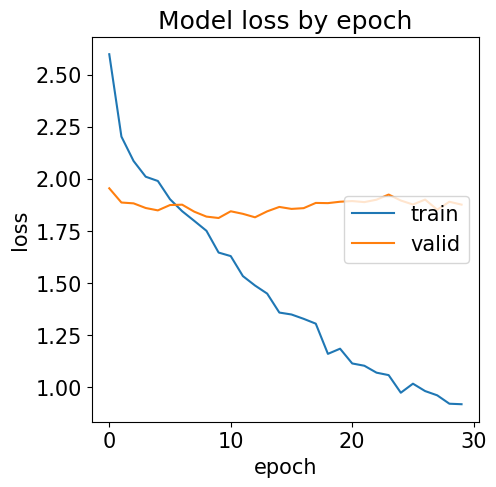

In [36]:
# Loss evolution
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

We no longer need the following variables, so let’s clean up the memory.

We observe the reduction of model loss on validation set, this means that we've impoved the model and it now makes fewer errors.

We've reduced the harshness of cross-entropy and allowed for the model to consider the flexibility of the predicted environment (by changing to tensorflow.keras.losses.CategoricalCrossentropy and adding kernel_regularizer to prevent overfitting)

In [37]:
#Clean the memory!
%xdel X_train
%xdel X_test
%xdel y_train
%xdel y_test
gc.collect()

3990

# 5. Transfer learning: use the trained model for a new downstream task

Now, we want to use the model you have just trained for quality assessement of artificially made (modeled) environments of residues. In this section, we have two classes: 0 and 1. Class 1 means the central residue is comfortable in its environment (the environment is a natural and acceptable local frame for the arrangement of the atoms), and class 0 means otherwise.

For example, a positively charged amino acid tends to favor a negatively charged environment, while a large amino acid prefers a less tightly packed surrounding.

This analysis of acceptable and incorrect environments has numerous applications in protein science, including:

* Quality assessment of protein structure models and protein–protein docking conformations
* Protein design through deep mutational scanning
* Prediction of mutation affects on protein stability


## The input data: locally oriented cubes representing acceptable and incorrect environments

The command below downloads the dataset. This dataset contains interfacial residue samples with their local environments encoded as cubes and target labels of 0 or 1.

In [38]:
!gdown --id '1p4v821pVgICBnWudFIuScFjPFiCzrF4F'

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1p4v821pVgICBnWudFIuScFjPFiCzrF4F
From (redirected): https://drive.google.com/uc?id=1p4v821pVgICBnWudFIuScFjPFiCzrF4F&confirm=t&uuid=0d994e03-55ff-4f86-8a8b-951ac89938d5
To: /content/traindata_env_class01.zip
100% 50.7M/50.7M [00:01<00:00, 39.6MB/s]


The command below decompresses the dataset.

In [39]:
!unzip -o -q '/content/traindata_env_class01.zip'

The commands below create a list of all the samples with target values 1 and 0.

In [40]:
samples_0 = glob.glob(os.path.join('traindata_env_class01', '0', '*'))
samples_1 = glob.glob(os.path.join('traindata_env_class01', '1', '*'))
samples = samples_1 + samples_0
shuffle(samples)
#correct and incorrect environments

Next, we will load all the samples and create two variables: `X`, containing the cubic information, and `y`, containing the target labels.

In [41]:
X, y = [],[]
X_train, X_test, y_train, y_test = [],[],[],[]
for sample in tqdm(samples_1[:25]):
  #print('Loading ' + sample)
  sample_X, sample_y, sample_resname = load_obj(sample.replace('.pkl',''))
  sample_X = reduce_channels(sample_X)
  X.append(np.array(sample_X))
  y.append(1)
for sample in samples_0[:25]:
  #print('Loading ' + sample)
  sample_X, sample_y, sample_resname = load_obj(sample.replace('.pkl',''))
  sample_X = reduce_channels(sample_X)
  X.append(np.array(sample_X))
  y.append(0)
X = np.array(X)
y = np.array(y)

100%|██████████| 25/25 [00:00<00:00, 33.15it/s]


**Task 7**: Split data into train and test sets using `train_test_split` function from `scikit-learn`. Use `test_size=0.3`.

In [42]:
# YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_test.shape)

#X and y are no longer needed, so we delete them.
%xdel X
%xdel y
gc.collect()

(15, 24, 24, 24, 4)


0

## Pre-trained model as feature extractor

In this section, we will leverage the model we previously trained as a pre-trained model that has learned, to some extent, the nature of central residues from their local environments. We will use this model to transfer its learned knowledge to a downstream task, a classifier designed to distinguish between acceptable and incorrect residue environments.


**Task 8**: Create an intermediate model similar to the pre-trained one, except that its output is the neurons of the second hidden layer of the fully connected network. Use the name you assigned to the second hidden layer (e.g., `layer2`).

Hint: Use the `Model` class from `Keras` along with the trained model object to create an `intermediate_model`. It can be written in just one line!

In [43]:
# The 'model' object is already created and trained in the previous cells.
# We just need to create the intermediate_model from it.
intermediate_model = Model(
    inputs=model.input,
    outputs=model.get_layer('layer2').output
)

Now extract the **features (also known as embeddings)** from the train and test sets. Hint: Use the `predict` function of `intermediate_model` object.

In [44]:
# YOUR CODE HERE
X_train_tr = intermediate_model.predict(X_train)
X_test_tr = intermediate_model.predict(X_test)

print(X_train_tr.shape)
print(y_train.shape)
#BINARY loss entropy: for binary classifications

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
(35, 64)
(35,)


## A shallow light model for the downstream task

**Task 9**: Create a shallow machine learning architecture for our downstream task of classifying residue environments. This model can be non-linear, such as a neural network, or linear, such as logistic regression.

This machine learning architecture is shallow, meaning it has relatively low complexity and fewer parameters compared to deep learning models. This makes it particularly well-suited for learning effectively from smaller training datasets.

Here, your goal is to design a feedforward neural network by specifying the number of hidden layers (one or two), the number of neurons in each layer, the activation functions, the loss function, and the learning rate.

In [16]:
# YOUR CODE HERE
def nn_model(input_shape):
    hidden_size1 = 10
    hidden_size2 = 5
    X_in = Input(shape=input_shape)
    H = Dense(hidden_size1, activation='elu', name='layer1')(X_in)
    H = Dense(hidden_size2, activation='elu', name='layer2')(H)
    Y = Dense(1, activation='sigmoid')(H)
    _model = Model(inputs=X_in, outputs=Y)
    _model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001))
    _model.summary()
    return _model

**Task 10**: Initiate training by following the instructions below:

* Define the number of epochs, such as 20 or 30.
* Specify a suitable batch size. We will perform mini-batch gradient descent.
* Construct the input dimensions. Hint: pay attention to the size of hidden layer you used to extract features (embeddings).
* Start training the model using the `fit` function.
* Hold out 30% of the date for validation.


In [49]:

# YOUR CODE HERE
num_epochs = 30
batch_size = 10
n_features_tr = X_train_tr.shape[1]

input_shape=(n_features_tr,)
model_tr = nn_model(input_shape)


history = model_tr.fit(X_train_tr, y_train, epochs=num_epochs, batch_size=batch_size, verbose = 1, validation_split=0.3)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 711 (2.78 KB)

 Trainable params: 711 (2.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 539ms/step - loss: 0.6562 - val_loss: 0.5521
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5788 - val_loss: 0.5083
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5383 - val_loss: 0.4724
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4838 - val_loss: 0.4411
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4704 - val_loss: 0.4142
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4290 - val_loss: 0.3903
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4055 - val_loss: 0.3703
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3717 - val_loss: 0.3527
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3377 - val_loss: 0.3375
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3239 - val_loss: 0.3251
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2917 - val_loss: 0.3137
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3191 - val_loss: 0.3029


Below, we use the history object to track the evolution of the training and validation losses and visualize them through plots.

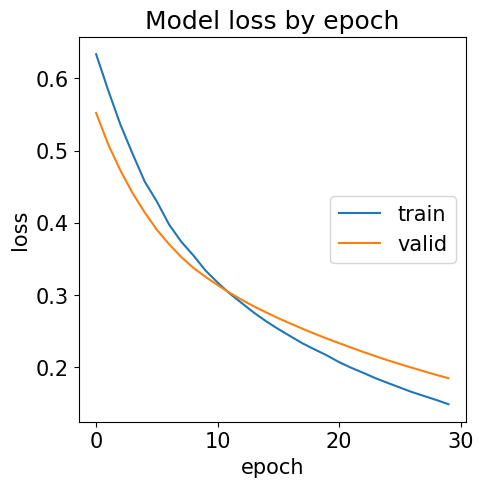

In [50]:
# Loss evolution
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

In the context of binary classification, the Receiver Operating Characteristic (ROC) curve is a graphical tool used to evaluate the performance of a classification model. It plots the True Positive Rate (TPR, sensitivity or recall) against the False Positive Rate (FPR or 1 - specificity) at various thresholds, providing a visual representation of the trade-off between correctly identifying positive cases and incorrectly classifying negative ones. The ROC curve helps assess how well a model distinguishes between classes, independent of class distribution or decision threshold, with the Area Under the Curve (AUC) serving as a single metric of overall model performance.

The code below uses the `scikit-learn` module to calculate the TPR and FPR at each threshold, compute the AUC, and visualize the ROC curve.

In [51]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [52]:
# plot no skill and model roc curves
def plot_roc_curve(test_y, naive_probs, model_probs):
	# plot naive skill roc curve
	fpr, tpr, _ = roc_curve(test_y, naive_probs)
	pyplot.plot(fpr, tpr, linestyle='--', label='No Skill')
	# plot model roc curve
	fpr, tpr, _ = roc_curve(test_y, model_probs)
	pyplot.plot(fpr, tpr, marker='.', label='Logistic')
	# axis labels
	pyplot.xlabel('False Positive Rate')
	pyplot.ylabel('True Positive Rate')
	# show the legend
	pyplot.legend()
	# show the plot
	pyplot.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
Transferred learning ROC AUC 1.000


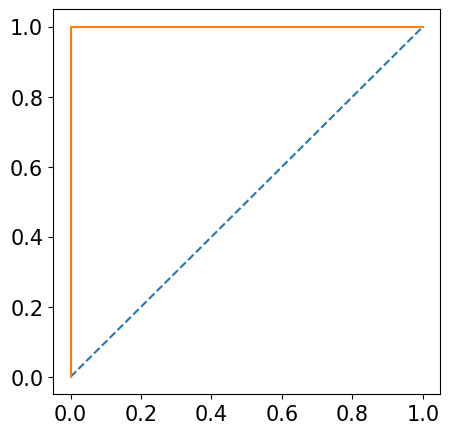

In [53]:
noskill = [0]*len(y_test)
y_pred = model_tr.predict(X_test_tr)
roc_auc = roc_auc_score(y_test, y_pred)
print('Transferred learning ROC AUC %.3f' % roc_auc)

ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill)
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 15})
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='NoSkill')
plt.plot(fpr, tpr, linestyle='-', label='Transferred Learning')
plt.show()

# Discussion: Towards Graph Neural Networks

While locally oriented cubes offer a straightforward way to represent amino acids and their surrounding local environments, they come with two key limitations:

1) Voxelized cubes are computationally expensive, requiring substantial GPU resources and memory.

2) Producing a protein-level prediction requires an additional aggregation scheme over local cubes.

Graph-based representation learning provides a compelling alternative that overcomes these challenges by modeling proteins more efficiently and holistically. Interested in learning more? Check out this Google Colab demonstrating how Graph Neural Networks can be used for protein structure representation learning.

https://colab.research.google.com/drive/1bbQE7PlnmDiQpX6wgx2Z75gHS0zMp3tA?usp=sharing

Designed by Yasser MOHSENI BEHBAHANI

Analytical Genomics, LCQB, Sorbonne Université, 2021

DSIMB, BIGR, Université Paris Cité, 2026

<img src='https://drive.google.com/uc?id=1Q2ZOG1aqY-837nX6Gd_ma4wUqfNyHOXG'>